In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv("Train.csv")

In [3]:
data_train.head()

,Order ID,Order Date,Country,City,State,Category,Product Name,Quantity,Profit
0,NM-2012-343889,26-04-2015,United States,Lambertfurt,Florida,Furnishings,Table Lamp,3,391.61
1,VA-2022-163003,26-04-2015,United States,West Jennifer,Nevada,Labels,Address Labels,3,579.75
2,KS-2015-985001,26-04-2015,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06
3,WI-2014-993323,27-04-2015,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,8,854.52
4,MO-2006-118786,27-04-2015,United States,West Adam,California,Accessories,Inkjet Printer Ink,6,167.34


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22291 entries, 0 to 22290
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22291 non-null  object 
 1   Order Date    22291 non-null  object 
 2   Country       22291 non-null  object 
 3   City          22291 non-null  object 
 4   State         22291 non-null  object 
 5   Category      22291 non-null  object 
 6   Product Name  22291 non-null  object 
 7   Quantity      22291 non-null  int64  
 8   Profit        22291 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.5+ MB


In [5]:
# Converting the object to timedate delta

data_train['Order Date'] = pd.to_datetime(data_train['Order Date'])

# Extract time components
data_train['Year'] = data_train['Order Date'].dt.year
data_train['Month'] = data_train['Order Date'].dt.month_name()
data_train['MonthNum'] = data_train['Order Date'].dt.month
data_train['DayOfWeek'] = data_train['Order Date'].dt.day_name()

In [6]:
# Dropping the column

data_train.drop('Order Date',axis=1,inplace=True)

In [7]:
data_train.sample(5)

,Order ID,Country,City,State,Category,Product Name,Quantity,Profit,Year,Month,MonthNum,DayOfWeek
10666,NJ-2011-161610,United States,Matthewfurt,Florida,Labels,Color Coding Labels,2,763.30,2020,January,1,Saturday
21463,RI-2013-318755,United States,Port Theresa,New York,Storage,Steel Filing Cabinet,6,225.06,2024,November,11,Saturday
15359,OR-2021-523775,United States,East Patricia,California,Storage,Vertical Stackable Tray,7,-12.68,2022,February,2,Thursday
2271,OR-2018-669939,United States,Ericland,Florida,Storage,Steel Filing Cabinet,1,201.69,2016,April,4,Wednesday
16445,TN-2006-286552,United States,Port Jimmyville,Nevada,Copiers,HP LaserJet Pro,6,773.32,2022,August,8,Sunday


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22291 entries, 0 to 22290
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      22291 non-null  object 
 1   Country       22291 non-null  object 
 2   City          22291 non-null  object 
 3   State         22291 non-null  object 
 4   Category      22291 non-null  object 
 5   Product Name  22291 non-null  object 
 6   Quantity      22291 non-null  int64  
 7   Profit        22291 non-null  float64
 8   Year          22291 non-null  int32  
 9   Month         22291 non-null  object 
 10  MonthNum      22291 non-null  int32  
 11  DayOfWeek     22291 non-null  object 
dtypes: float64(1), int32(2), int64(1), object(8)
memory usage: 1.9+ MB


In [9]:
data_train.isna().sum()

,0
Order ID,0
Country,0
City,0
State,0
Category,0
Product Name,0
Quantity,0
Profit,0
Year,0
Month,0


Obs: No null values in data

In [10]:
data_train.duplicated().sum()

np.int64(0)

Obs: No Duplicated values in data

In [11]:
data_train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Order ID,22291,22291,NV-2008-738206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,22291,1,United States,22291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,22291,14417,Port Michael,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,22291,10,Ohio,2283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,22291,5,Storage,4637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product Name,22291,15,Mobile Pedestal,1586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,22291.0,NaN,NaN,NaN,5.518101,2.865486,1.0,3.0,6.0,8.0,10.0
Profit,22291.0,NaN,NaN,NaN,398.797705,345.353033,-199.89,99.45,396.44,696.15,999.97
Year,22291.0,NaN,NaN,NaN,2019.764658,2.883372,2015.0,2017.0,2020.0,2022.0,2025.0
Month,22291,12,January,1931,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print("Unique values per column")
data_train.nunique().sort_values(ascending = True)

Unique values per column


,0
Country,1
Category,5
DayOfWeek,7
Quantity,10
State,10
Year,11
MonthNum,12
Month,12
Product Name,15
City,14417


In [13]:
for i in data_train.columns:
    print(f"Unique value in {i}")
    print(data_train[i].unique() , '\n')

Unique value in Order ID
['NM-2012-343889' 'VA-2022-163003' 'KS-2015-985001' ... 'LA-2001-826832'
 'GA-2021-314162' 'NV-2008-738206'] 

Unique value in Country
['United States'] 

Unique value in City
['Lambertfurt' 'West Jennifer' 'West Melvinborough' ... 'Victorburgh'
 'Cochranshire' 'Nicholashaven'] 

Unique value in State
['Florida' 'Nevada' 'California' 'Ohio' 'Washington' 'Idaho' 'Georgia'
 'New York' 'Illinois' 'Texas'] 

Unique value in Category
['Furnishings' 'Labels' 'Storage' 'Accessories' 'Copiers'] 

Unique value in Product Name
['Table Lamp' 'Address Labels' 'Vertical Stackable Tray'
 'Inkjet Printer Ink' 'Canon ImageRunner' 'HP LaserJet Pro'
 'Color Coding Labels' 'Shipping Labels' 'Office Chair' 'Standing Desk'
 'Steel Filing Cabinet' 'Xerox 3000' 'Mobile Pedestal' 'Calculator'
 'Stapler'] 

Unique value in Quantity
[ 3  8  6  4  5  7  9  2 10  1] 

Unique value in Profit
[ 391.61  579.75 -118.06 ...  242.42  287.97  102.1 ] 

Unique value in Year
[2015 2016 2017 2018 2

In [14]:
data_less_than_zero = data_train.loc[data_train['Profit'] < 0]
data_less_than_zero

,Order ID,Country,City,State,Category,Product Name,Quantity,Profit,Year,Month,MonthNum,DayOfWeek
2,KS-2015-985001,United States,West Melvinborough,Florida,Labels,Address Labels,3,-118.06,2015,April,4,Sunday
8,IA-2018-124785,United States,Smithborough,California,Labels,Color Coding Labels,5,-95.11,2015,April,4,Monday
12,KS-2001-255768,United States,Tammymouth,Idaho,Accessories,Inkjet Printer Ink,9,-73.92,2015,April,4,Wednesday
15,NC-2003-260265,United States,Natashaport,New York,Furnishings,Table Lamp,7,-123.77,2015,April,4,Wednesday
18,NJ-2025-907346,United States,Lake Alexis,New York,Copiers,Xerox 3000,4,-149.39,2015,April,4,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...
22257,SD-2017-757648,United States,Port Danland,Washington,Copiers,Canon ImageRunner,8,-97.64,2025,March,3,Sunday
22259,MT-2004-701666,United States,South Veronica,Ohio,Labels,Shipping Labels,5,-45.23,2025,March,3,Sunday
22266,DC-2020-298494,United States,Huntside,Texas,Copiers,Xerox 3000,3,-150.04,2025,March,3,Tuesday
22279,SC-2008-342550,United States,Freyfort,Illinois,Furnishings,Standing Desk,10,-62.87,2025,March,3,Thursday


In [21]:
#Numerical Features

numerical_feature = [feature for feature in data_train.columns if data_train[feature].dtype != 'O']
print("No. of Numerical Column: ",len(numerical_feature))
data_train[numerical_feature].head()

No. of Numerical Column:  4


,Quantity,Profit,Year,MonthNum
0,3,391.61,2015,4
1,3,579.75,2015,4
2,3,-118.06,2015,4
3,8,854.52,2015,4
4,6,167.34,2015,4


In [22]:
# Categorical Columns

categorical_feature = [feature for feature in data_train.columns if data_train[feature].dtype == 'O']
print("No. of Categorical Column: ",len(categorical_feature))
data_train[categorical_feature].head()

No. of Categorical Column:  8


,Order ID,Country,City,State,Category,Product Name,Month,DayOfWeek
0,NM-2012-343889,United States,Lambertfurt,Florida,Furnishings,Table Lamp,April,Sunday
1,VA-2022-163003,United States,West Jennifer,Nevada,Labels,Address Labels,April,Sunday
2,KS-2015-985001,United States,West Melvinborough,Florida,Labels,Address Labels,April,Sunday
3,WI-2014-993323,United States,Jensenfurt,Florida,Storage,Vertical Stackable Tray,April,Monday
4,MO-2006-118786,United States,West Adam,California,Accessories,Inkjet Printer Ink,April,Monday


In [23]:
# Correlation Analysis

data_train[numerical_feature].corr()

,Quantity,Profit,Year,MonthNum
Quantity,1.000000,-0.002576,0.007488,0.005977
Profit,-0.002576,1.000000,0.001884,0.011477
Year,0.007488,0.001884,1.000000,-0.117312
MonthNum,0.005977,0.011477,-0.117312,1.000000


Obs - There is no strong correlation among the numerical features, indicating they are largely independent of each other.

In [24]:
# Skewness

data_train[numerical_feature].skew()

,0
Quantity,0.000204
Profit,0.003926
Year,-0.003354
MonthNum,-0.013855


Obs: The distributions of numerical features are approximately symmetric and it not skewed right or left.

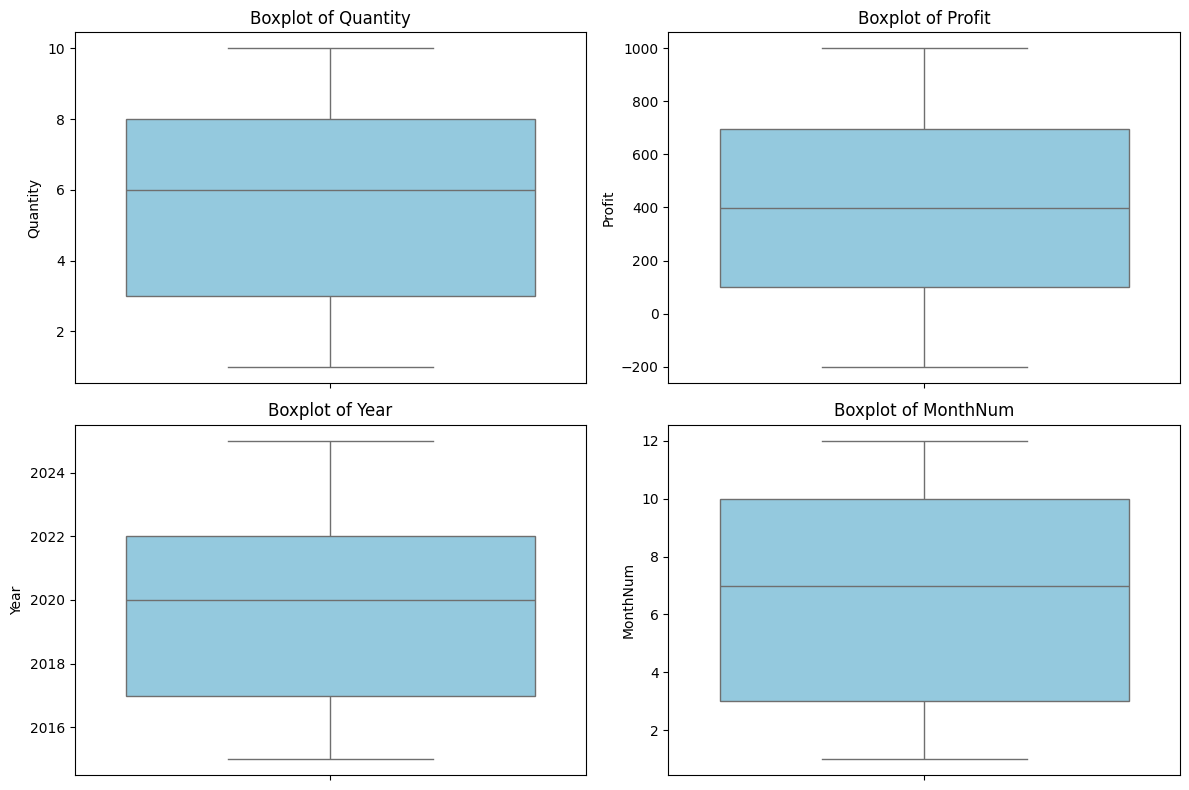

In [26]:
# Outlier Detection

plt.figure(figsize = (12,8))
for i,feature in enumerate(numerical_feature,1):
  plt.subplot(2,2,i)
  sns.boxplot(data=data_train,y=feature,color='skyblue')
  plt.title(f"Boxplot of {feature}")
  plt.tight_layout()
plt.show()

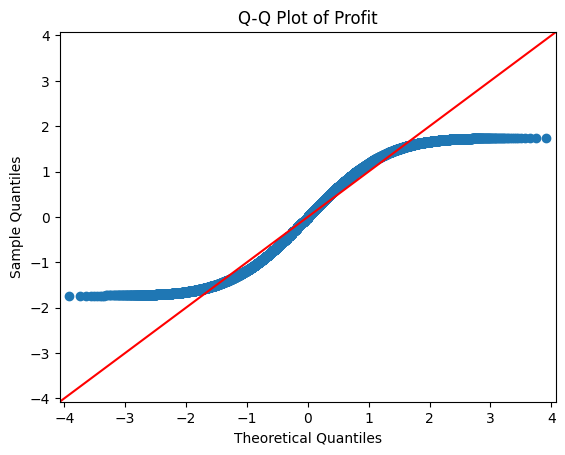

In [30]:
import statsmodels.api as sm

sm.qqplot(data_train['Profit'], line='45', fit=True)
plt.title("Q-Q Plot of Profit")
plt.show()


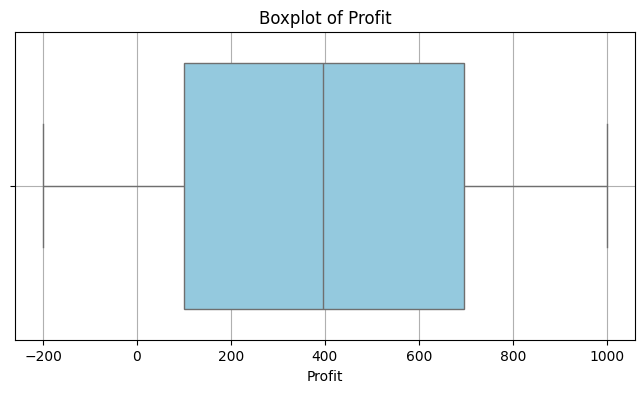

In [15]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data_train['Profit'], color='skyblue')
plt.title('Boxplot of Profit')
plt.xlabel('Profit')
plt.grid(True)
plt.show()

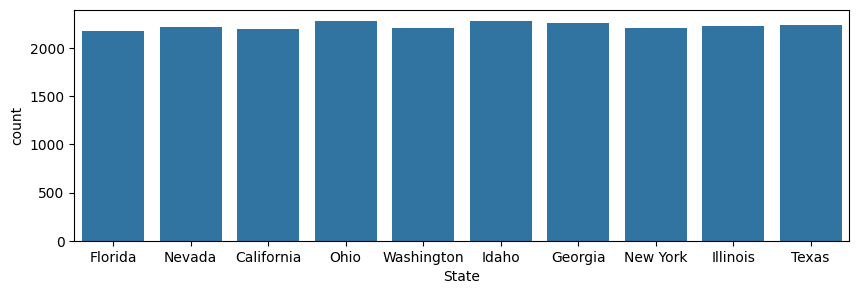

In [16]:
plt.figure(figsize = (10,3))
sns.countplot(data=data_train, x='State')
plt.show()

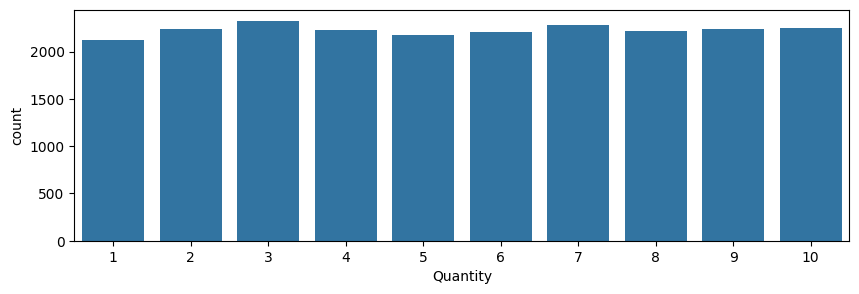

In [17]:
plt.figure(figsize = (10,3))
sns.countplot(data=data_train, x='Quantity')
plt.show()

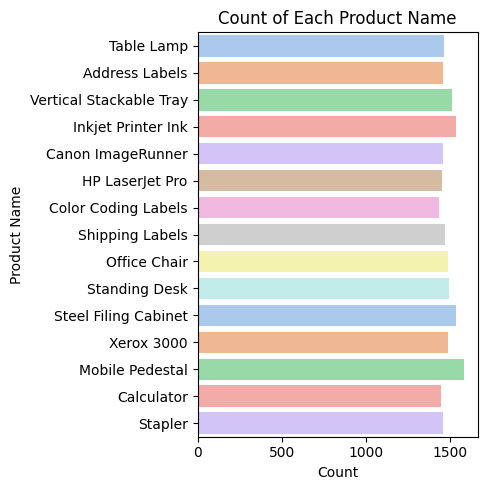

In [18]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data_train, y='Product Name', palette='pastel')
plt.title('Count of Each Product Name')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

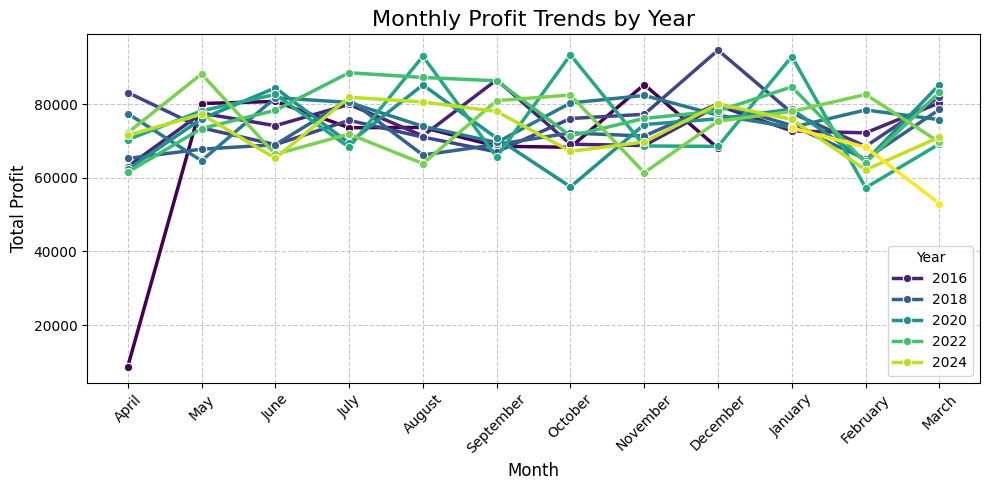

In [19]:
monthly_profit = data_train.groupby(['Year', 'MonthNum', 'Month'])['Profit'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_profit, x='Month', y='Profit', hue='Year',
             marker='o', linewidth=2.5, palette='viridis')
plt.title('Monthly Profit Trends by Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Profit', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

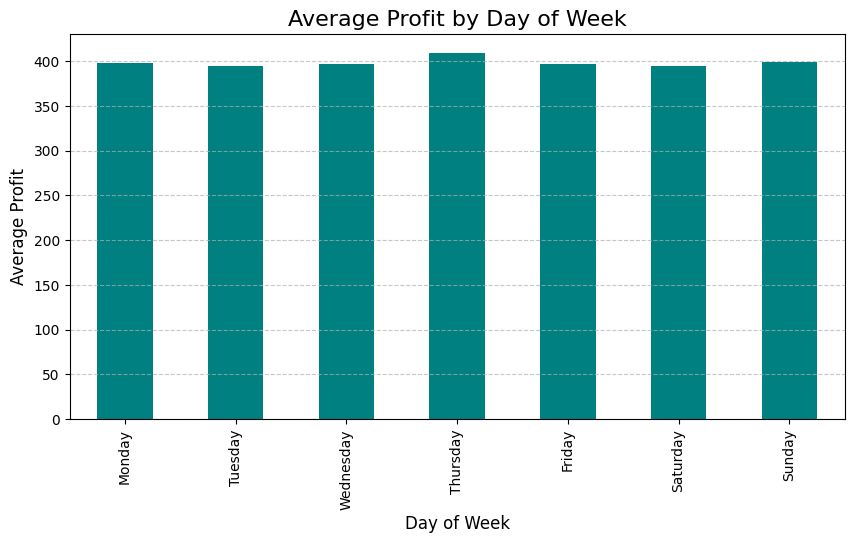

In [20]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_profit = data_train.groupby(['DayOfWeek'])['Profit'].mean().reindex(day_order)

plt.figure(figsize=(10, 5))
daily_profit.plot(kind='bar', color='teal')
plt.title('Average Profit by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Profit', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()